In [1]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
synth = pd.read_csv('data/cbi_synthetic_on_train_1080.csv')

In [4]:
train = pd.read_excel('data/cbi_train_set.xlsx')
test = pd.read_excel('data/cbi_test_set.xlsx')

In [5]:
synth['origin'] = 'synth'
train['origin'] = 'train'
test['origin'] = 'test'

In [6]:
# taking n samples from total of 1080 synthetic samples
synth_n = synth.sample(n=100)

In [7]:
data_synth = pd.concat([synth_n, train])

---

In [8]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad',
    'origin'
]

In [9]:
data_synth.isna().sum()

location                                                         0
emirates                                                         0
gender                                                           0
family_status                                                    0
employment_sphere                                                0
collateral                                                       0
type_of_product                                                  0
employment_level                                                 0
loan_amount                                                      0
duration_at_disbursement_months                                  0
interest_rate                                                    0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
age                                                              0
monthly_income_aed                                               0
work_experience                                               

In [10]:
data_synth.dropna(subset=cat_feats+num_feats, inplace=True)
test.dropna(subset=cat_feats+num_feats, inplace=True)


---

In [11]:
# Target mean encoding #
for feat in cat_feats:
    stats = train[target].groupby(train[feat]).agg(['count', 'mean'])
    data_synth[feat+'_mean_encoded'] = data_synth[feat].copy()
    test[feat+'_mean_encoded'] = test[feat].copy()
    
    for i in data_synth[feat+'_mean_encoded'].unique():
        data_synth[feat+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)
        test[feat+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

---

In [12]:
# Removing classes that are in test set but not in train set #
for i in test.index :
    for feat in cat_feats :
        if type(test[feat+'_mean_encoded'][i]) == str:
            test.drop(i, inplace=True)
            break

In [13]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

---

In [14]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(data_synth.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns :
            print(i)

All variables are found in feature lists


In [15]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(data_synth.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

True

# Modeling
---

In [16]:
train = data_synth[data_synth['origin'] == 'train']

In [17]:
data_synth.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

In [18]:
exp = ClassificationExperiment()
exp.setup(
    data = data_synth,
    test_data = test,
    target = target,
    index = False,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False
)

,Description,Value
0,Session id,1522
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(2783, 42)"
4,Transformed data shape,"(2783, 21)"
5,Transformed train set shape,"(2255, 21)"
6,Transformed test set shape,"(528, 21)"
7,Ignore features,21
8,Numeric features,20
9,Rows with missing values,5.2%


In [19]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.01,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8226,0.7898,0.3000,0.6136,0.4030,0.3129,0.3407
1,0.8559,0.8521,0.3111,0.9032,0.4628,0.4016,0.4783
2,0.8271,0.8471,0.3000,0.6429,0.4091,0.3231,0.3554
3,0.8315,0.7712,0.2637,0.7273,0.3871,0.3134,0.3679
4,0.8293,0.8085,0.2857,0.6842,0.4031,0.3226,0.3646
Mean,0.8333,0.8137,0.2921,0.7142,0.4130,0.3347,0.3814
Std,0.0117,0.0316,0.0163,0.1020,0.0259,0.0337,0.0494


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8030,0.7919,0.1682,0.5455,0.2571,0.1787,0.2202


{'0': {'precision': 0.8920308483290489,
       'recall': 0.8242280285035629,
       'f1-score': 0.8567901234567903,
       'support': 421},
 '1': {'precision': 0.4676258992805755,
       'recall': 0.6074766355140186,
       'f1-score': 0.5284552845528455,
       'support': 107},
 'accuracy': 0.7803030303030303,
 'macro avg': {'precision': 0.6798283738048122,
               'recall': 0.7158523320087908,
               'f1-score': 0.6926227040048178,
               'support': 528},
 'weighted avg': {'precision': 0.8060245423665742,
                  'recall': 0.7803030303030303,
                  'f1-score': 0.7902525708758772,
                  'support': 528},
 'threshold': 0.25,
 'TN': 347,
 'FP': 74,
 'FN': 42,
 'TP': 65,
 'AUC': 0.7918,
 'model NPL': 10.8,
 ' real NPL': 20.27,
 'approval rate': 73.67,
 'good correct': 82.42,
 'bad correct': 60.75}


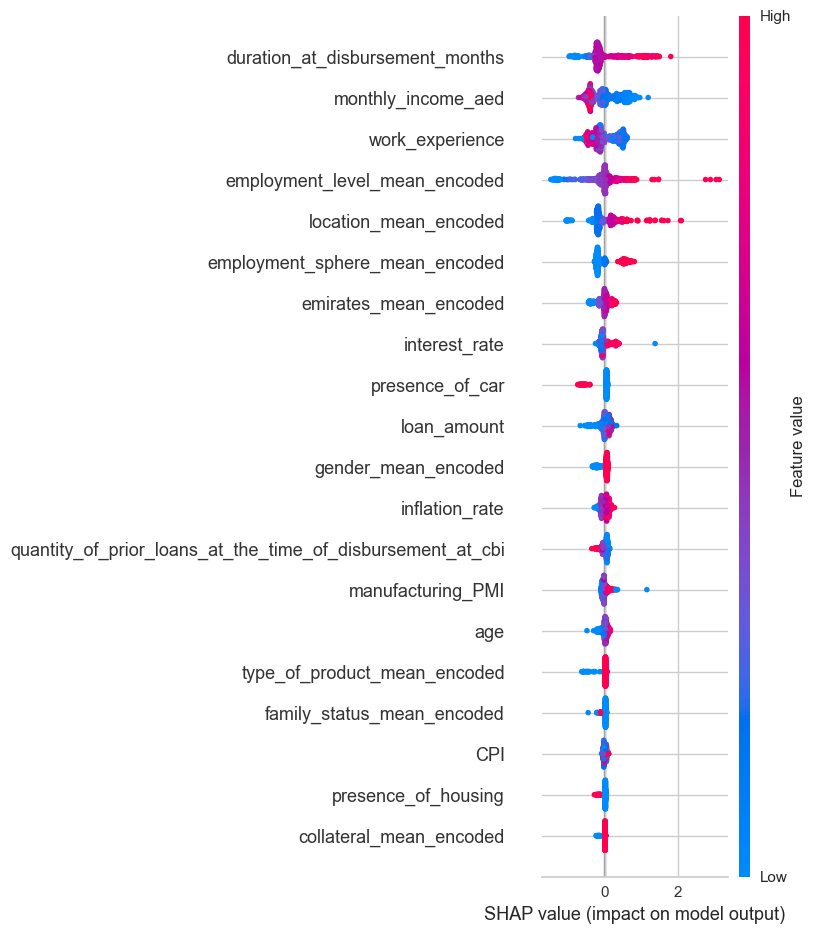

In [22]:
exp.interpret_model(trained_model_catboost)